# 基于PaddlePaddle的A股预测

> 本项目尝试通过百度自研PaddlePaddle框架实现深度神经网络DNN和长短期记忆网络LSTM来对A股进行预测，使用数据为2000-2021年上证50的数据

本项目[Github仓库](https://github.com/chaoers/stock-prediction)

## 运行环境

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers

### GPU(CPU)调用

In [2]:
# place = fluid.CUDAPlace(0) # GPU环境用这个
place = fluid.CPUPlace() # CPU环境用这个

## 数据清洗

### 导入数据

In [3]:
data_pd = pd.read_csv('./data/data72449/shangzheng.csv')

### 查看数据头部

In [4]:
data_pd.head()
# data.tail()
# data.describe()
# data.info()

,date,over,begin,high,low,trade,wave
0,2000年1月4日,1406.37,1368.69,1407.52,1361.21,437.09M,2.91%
1,2000年1月5日,1409.68,1407.83,1433.78,1398.32,688.09M,0.24%
2,2000年1月6日,1463.94,1406.04,1463.95,1400.25,809.05M,3.85%
3,2000年1月7日,1516.60,1477.15,1522.83,1477.15,1.60B,3.60%
4,2000年1月10日,1545.11,1531.71,1546.72,1506.40,1.51B,1.88%


### 异常项清洗

In [5]:
data_pd.info() # 没有异常项需要处理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5130 non-null   object 
 1   over    5130 non-null   float64
 2   begin   5130 non-null   float64
 3   high    5130 non-null   float64
 4   low     5130 non-null   float64
 5   trade   5130 non-null   object 
 6   wave    5130 non-null   object 
dtypes: float64(4), object(3)
memory usage: 280.7+ KB


### 画图查看数据

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


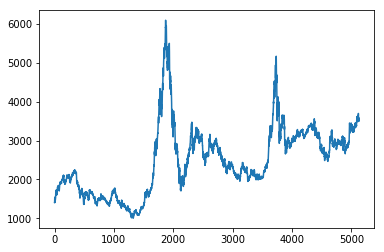

In [6]:
plt.plot(data_pd['over'])

### 提取需要数据并格式化

In [7]:
data_pd.set_index('date', inplace=True)
data_pd.drop(columns=['trade', 'wave'], inplace=True)
data_pd.head()

,over,begin,high,low
date,,,,
2000年1月4日,1406.37,1368.69,1407.52,1361.21
2000年1月5日,1409.68,1407.83,1433.78,1398.32
2000年1月6日,1463.94,1406.04,1463.95,1400.25
2000年1月7日,1516.60,1477.15,1522.83,1477.15
2000年1月10日,1545.11,1531.71,1546.72,1506.40


### 标准化数据

> 在这里只能通过训练集特征来对全部数据进行标准化，因为理论来说我们只知道当前时间之前的数据。详见[我的博客](https://www.asteriscum.cn/2021/03/03/53/21/), 所以这里就要确认数据集划分比例

In [8]:
split_boundary = int(data_pd.shape[0] * 0.8)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_pd[:split_boundary])
data_transform = scaler.transform(data_pd)

# data_transform

### 建立时间滑窗，我们使用前5天数据来预测后一天的数据

In [9]:
sequence_length = 5
delay = 1
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=sequence_length+delay):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

data = create_sequences(data_transform)
print("Training input shape: ", data.shape)

Training input shape:  (5124, 6, 4)


### 划分训练集和测试集

In [10]:
train = data[: split_boundary]
test = data[split_boundary:]

train.shape,test.shape

((4104, 6, 4), (1020, 6, 4))

### 建立batch生成器

In [11]:
def switch_reader(is_val: bool = False):
    def reader():
        # 判断是否是验证集
        if is_val:
            # 抽取数据使用迭代器返回
            for te in test:
                yield te[:sequence_length],te[-1:][:,0]
        else:
            # 抽取数据使用迭代器返回
            for tr in train:
                yield tr[:sequence_length],tr[-1:][:,0]#只取第0列pm2.5的值为label
        
    return reader   # 注意！此处不需要带括号

#### 测试batch生成器

In [12]:
batch_size = 128
train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
for data in train_reader():
    # print(data[0].shape,data[1].shape)
    train_x=np.array([x[0] for x in data],np.float32)
    train_y = np.array([x[1] for x in data]).astype('int64')
    print(train_x.shape,train_y.shape)

(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(8, 5, 4) (8, 1)


## DNN网络

### 定义DNN网络

In [13]:
class MyDNNModel(fluid.dygraph.Layer):
    '''
    DNN网络
    '''
    def __init__(self):
        super(MyDNNModel,self).__init__()
        self.fc1=fluid.dygraph.Linear(5*4,10,act='relu')
        self.fc2=fluid.dygraph.Linear(10,1)
        
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        '''前向计算'''
        # print('input',input.shape)
        input =fluid.layers.reshape(input,shape=[-1,5*4])
        out=self.fc1(input)
        out=self.fc2(out)
        # print(out.shape)
        return out

### 损失作图函数

In [14]:
def draw_train_loss(Batchs, train_loss,eval_loss, label=""):
    # print(len(Batchs), len(train_loss), len(eval_loss))
    plt.figure(figsize=(10, 6))
    title= label + " training-eval loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.plot(Batchs, eval_loss, color='g', label='eval loss')
    plt.legend()
    plt.grid()
    plt.savefig('./img/'+ label + '_loss.png', dpi=300)
    plt.show()

    # print(Batchs, train_loss)

### 开始训练

> 注：有时训练DNN会出现损失函数反常现象，这时请再次运行训练

epoch:0,batch_id:10,train_loss:[0.00943683],eval_loss:0.008324659817541638
epoch:1,batch_id:10,train_loss:[0.00666316],eval_loss:0.00575822366711994
epoch:2,batch_id:10,train_loss:[0.00455487],eval_loss:0.0038302813190966845
epoch:3,batch_id:10,train_loss:[0.00304223],eval_loss:0.0024680186567517617
epoch:4,batch_id:10,train_loss:[0.00203338],eval_loss:0.0015793565932350855
epoch:5,batch_id:10,train_loss:[0.00142026],eval_loss:0.0010583313123788685
epoch:6,batch_id:10,train_loss:[0.00109477],eval_loss:0.000800652390656372
epoch:7,batch_id:10,train_loss:[0.00096088],eval_loss:0.0007148502045311034
epoch:8,batch_id:10,train_loss:[0.00094103],eval_loss:0.0007278764775643746
epoch:9,batch_id:10,train_loss:[0.0009787],eval_loss:0.0007871450701107582
epoch:10,batch_id:10,train_loss:[0.00103715],eval_loss:0.0008587861860481402
epoch:11,batch_id:10,train_loss:[0.0010949],eval_loss:0.0009239346254616976
epoch:12,batch_id:10,train_loss:[0.00114178],eval_loss:0.0009743596310727298
epoch:13,batch_

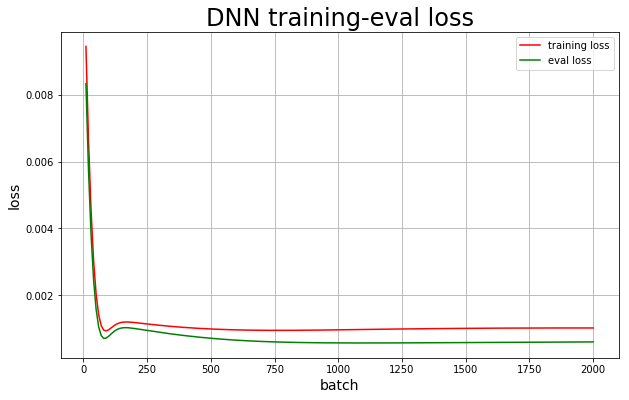

In [21]:
with fluid.dygraph.guard(place):
    model=MyDNNModel() #模型实例化
    model.train() #训练模式
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.0001, parameter_list=model.parameters()) 
    epochs_num=200#迭代次数
    batch_size = 128 * 3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])#获取loss值
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'./model/MyDNNModel')#保存模型
    fluid.save_dygraph(opt.state_dict(),'./model/MyDNNModel')#保存模型
    print("Final loss: {}".format(avg_loss.numpy()))    
#绘制训练图和验证损失图，以了解训练的进行情况。     
draw_train_loss(Batchs,all_train_loss,all_eval_loss, 'DNN')

## LSTM网络

### 定义LSTM网络

In [16]:
import paddle.fluid as fluid
class MyLSTMModel(fluid.dygraph.Layer):
    '''
    LSTM网络
    '''
    def __init__(self):
        super(MyLSTMModel,self).__init__()
        self.rnn = paddle.nn.LSTM(4, 20, 2)
        self.flatten = paddle.nn.Flatten()
        self.fc1=fluid.dygraph.Linear(5*20,10)
        self.fc2=fluid.dygraph.Linear(10,1)

        
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        '''前向计算'''
        # print('input',input.shape)
        out, (h, c)=self.rnn(input)
        out =self.flatten(out)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

### 开始训练

epoch:0,batch_id:10,train_loss:[0.02328011],eval_loss:0.03692121555407842
epoch:1,batch_id:10,train_loss:[0.05825887],eval_loss:0.03277343697845936
epoch:2,batch_id:10,train_loss:[0.00764907],eval_loss:0.01722867600619793
epoch:3,batch_id:10,train_loss:[0.00988212],eval_loss:0.007318180985748768
epoch:4,batch_id:10,train_loss:[0.0008091],eval_loss:0.001431947690434754
epoch:5,batch_id:10,train_loss:[0.00110962],eval_loss:0.0006655518373008817
epoch:6,batch_id:10,train_loss:[0.00120124],eval_loss:0.0006069704929056267
epoch:7,batch_id:10,train_loss:[0.00417768],eval_loss:0.003968538638825218
epoch:8,batch_id:10,train_loss:[0.00132585],eval_loss:0.0008432210597675294
epoch:9,batch_id:10,train_loss:[0.0010052],eval_loss:0.0010523064993321896
epoch:10,batch_id:10,train_loss:[0.001807],eval_loss:0.0006540715112350881
epoch:11,batch_id:10,train_loss:[0.00189963],eval_loss:0.0020179497466112175
epoch:12,batch_id:10,train_loss:[0.00119211],eval_loss:0.0009217111898275713
epoch:13,batch_id:10,t

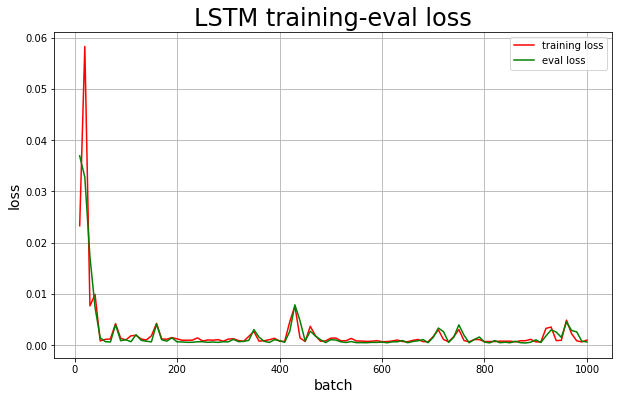

In [17]:
with fluid.dygraph.guard(place):
    model=MyLSTMModel() #模型实例化
    # model=MyModel()
    model.train() #训练模式
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=0.001, parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.01, parameter_list=model.parameters()) 
    epochs_num=100#迭代次数
    batch_size = 128*3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])#获取loss值
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'./model/MyLSTMModel')#保存模型
    fluid.save_dygraph(opt.state_dict(),'./model/MyLSTMModel')#保存模型
    print("Final loss: {}".format(avg_loss.numpy()))    
#让我们绘制训练图和验证损失图，以了解训练的进行情况。     
draw_train_loss(Batchs,all_train_loss,all_eval_loss, 'LSTM')

## 训练结果

### 预测结果

#### 数据集还原函数

> 开始时标准化的函数需要在实际作图时还原

In [18]:
def inverse_transform(arr):
    zero_arr = np.zeros((arr.shape[0], 3))
    zero_data = np.hstack((arr, zero_arr))
    # print(zero_data)
    zero_data = scaler.inverse_transform(zero_data)
    # print(zero_data)
    
    return zero_data[:, 0]


#### 训练集数据预测结果

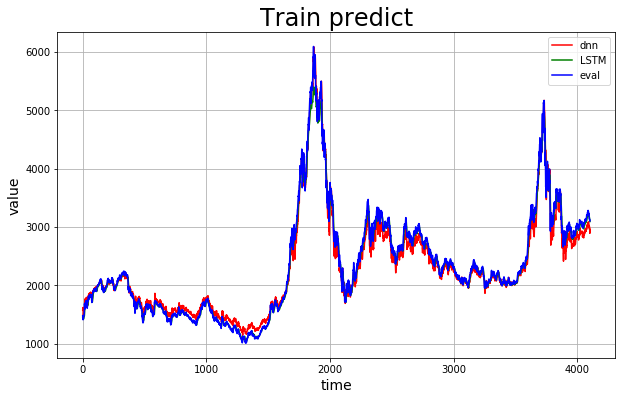

In [19]:
with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('./model/MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('./model/MyDNNModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyDNNModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) #加载模型参数

    train_reader = fluid.io.batch(reader=switch_reader(is_val=False), batch_size=train.shape[0])
    train_data_x = np.array([x[0] for x in next(train_reader())],np.float32)
    train_data_y = np.array([x[1] for x in next(train_reader())]).astype('float32')

    train_data_x = fluid.dygraph.to_variable(train_data_x)
    train_data_y = fluid.dygraph.to_variable(train_data_y)

    train_dnn=model_dnn(train_data_x)
    train_lstm=model_lstm(train_data_x)

plt.figure(figsize=(10, 6))
title="Train predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.plot(range(train.shape[0]), inverse_transform(train_dnn.numpy()), color='red', label='dnn')
plt.plot(range(train.shape[0]), inverse_transform(train_lstm.numpy()), color='g', label='LSTM')
plt.plot(range(train.shape[0]), inverse_transform(train_data_y.numpy()), color='b', label='eval')
plt.legend()
plt.grid()
plt.savefig('./img/train_res.png', dpi=300)
plt.show()

#### 验证集预测结果

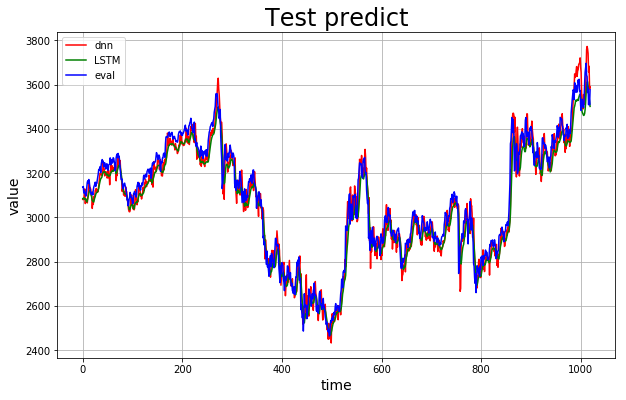

In [22]:
with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('./model/MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('./model/MyDNNModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyDNNModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) #加载模型参数

    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=test.shape[0])
    # print(len(next(val_reader())))
    eval_data_x = np.array([x[0] for x in next(val_reader())],np.float32)
    eval_data_y = np.array([x[1] for x in next(val_reader())]).astype('float32')

    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

    eval_dnn=model_dnn(eval_data_x)
    eval_lstm=model_lstm(eval_data_x)

plt.figure(figsize=(10, 6))
title="Test predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.plot(range(test.shape[0]), inverse_transform(eval_dnn.numpy()), color='red', label='dnn')
plt.plot(range(test.shape[0]), inverse_transform(eval_lstm.numpy()), color='g', label='LSTM')
plt.plot(range(test.shape[0]), inverse_transform(eval_data_y.numpy()), color='b', label='eval')
plt.legend()
plt.grid()
plt.savefig('./img/test_res.png', dpi=300)
plt.show()


## 模型改进

- 本项目两模型每次训练结果具有差异性(LSTM稳定性较好一点，DNN稳定性较差)，预测结果不理想时可以尝试再次训练
- 同时模型结构未做很多尝试，在训练过程中尝试改变模型参数(模型层数，节点数量等)发现预测效果好上不少，应该还有很大的提升空间，小伙伴们可以尝试一下

## 关于作者

### Asterisk(Fan Guofan)

> 西安交通大学 本科在读

- Mail: [fanguofan@asteriscum.cn](mailto:fanguofan@asteriscum.cn)
- Github: [chaoers](https://github.com/chaoers)
- 个人博客: [饭饭的快乐屋](https://www.asteriscum.cn)
- Ai studio: [Asterisk](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/686105)